# CSE4212: Artificail Intelligence Lab
### **Date:** 2 March, 2024

## Group 2:

- Nazmus Shakib

  **ID:** 1910876105

  **Session:** 2018-19

- Md. Ahanaf Arif Khan
  
  **ID:** 1910676110

  **Session:** 2018-19

- Farjana Aktar,

  **ID:** 1912276145

  **Session:** 2018-19

- Mohammad Ashif,

  **ID:** 1711076147

  **Session:** 2016-17

# Assignment5 (Group-wise Submission)

Write a report on the effect of transfer learning on binary classification done by your own model using your private dataset.

# Mount Google Drive

Our dataset is stored in Google Drive. So, we need to mount drive first in order to load the dataset.

In [82]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 

# https://github.com/tensorflow/tensorflow/issues/53519
os.environ['TF_DEVICE_MIN_SYS_MEMORY_IN_MB'] = '64' 

In [83]:
# from google.colab import drive
# drive.mount('/content/drive')

# Import Dependencies

In [84]:
import tensorflow as tf
from tensorflow import keras
from keras import Input, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from keras.metrics import CategoricalAccuracy, BinaryAccuracy, Precision, Recall, F1Score
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications import vgg16
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Hyper-Parameters

In [85]:
batch_size = 32
image_size = (256, 256)
learning_rate = 1e-4
epochs = 30
label_mode = 'int'
monitor_metric = 'val_loss'

# Loading the Dataset

The dataset is stored as a zip file in google drive. First, we need to extract it.

In [86]:
dataset_base_path = '.'
db_name = 'dataset_256'
!unzip -o -q '{dataset_base_path}/{db_name}'

Create a dataset object for train, validation and test datasets respectively.

In [87]:
train_ds = keras.utils.image_dataset_from_directory(
    f'{db_name}/train',
    image_size=image_size,
    batch_size=batch_size,
    label_mode=label_mode,
    shuffle=True
)

val_ds = keras.utils.image_dataset_from_directory(
    f'{db_name}/valid',
    image_size=image_size,
    batch_size=batch_size,
    label_mode=label_mode,
    shuffle=False
)

test_ds = keras.utils.image_dataset_from_directory(
    f'{db_name}/test',
    image_size=image_size,
    batch_size=batch_size,
    label_mode=label_mode,
    shuffle=False
)

# Used for plotting
class_names = train_ds.class_names


test_ds = test_ds.map(lambda x, y: (x, tf.cast(y, tf.float32)))
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

Found 782 files belonging to 2 classes.


Found 106 files belonging to 2 classes.
Found 160 files belonging to 2 classes.


In [88]:
print(train_ds)
print(class_names)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
['book', 'notebook']


# Plot Samples from the Dataset

Our dataset contains images of books and notebooks. The images are of  resolution 256 x 256 pixels. Let us view a few samples from the dataset.

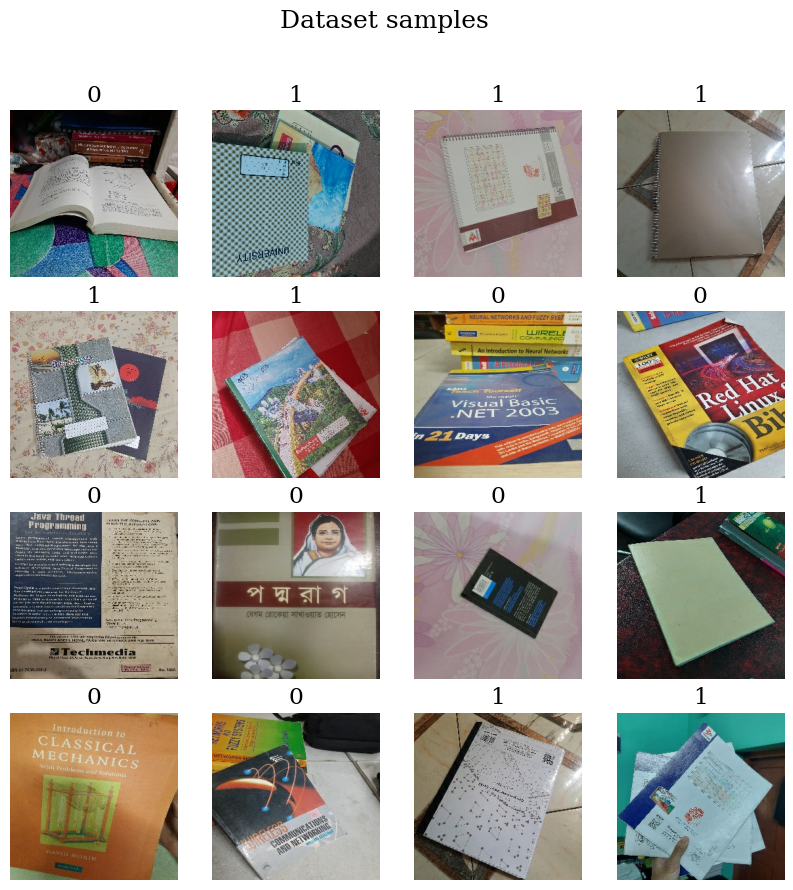

In [89]:
for imgs, labels in train_ds:
  break

plt.figure(figsize=(10, 10))
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 14

plt.suptitle('Dataset samples', fontsize=18)
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(imgs[i] / 255)
  plt.axis('off')
  # plt.title('{}({})'.format(class_names[labels[i]], labels[i]))
  plt.title(f'{labels[i]}'.format(class_names[labels[i]], labels[i]))

plt.savefig("./{}.png".format('dataset-samples'), bbox_inches='tight', format='png', dpi=256)
plt.show();

# VGG16 Model With Randomlly Initialized Weights

### Creating the VGG16 Model and Viewing its Summary

In [90]:
vgg16_model = vgg16.VGG16(include_top=False, weights=None, input_shape=image_size+(3,))

inputs = vgg16_model.input
x = Flatten()(vgg16_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

vgg16_model = keras.Model(inputs, outputs, name='VGG16_Model')
vgg16_model.summary()

Model: "VGG16_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       

### Compile and Fit the Model

In [91]:
vgg16_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=BinaryCrossentropy(),
    metrics=[BinaryAccuracy(name='accuracy')]
)

history = vgg16_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[
        ModelCheckpoint('vgg16_model-noTL.keras', monitor=monitor_metric, save_weights_only=False, save_best_only=True, verbose=1),
    ],
)

Epoch 1/30
25/25 [==============================] - ETA: 0s - loss: 0.7545 - accuracy: 0.4872
Epoch 1: val_loss improved from inf to 0.69206, saving model to vgg16_model-noTL.keras
25/25 [==============================] - 37s 696ms/step - loss: 0.7545 - accuracy: 0.4872 - val_loss: 0.6921 - val_accuracy: 0.5189
Epoch 2/30
25/25 [==============================] - ETA: 0s - loss: 0.6814 - accuracy: 0.5499
Epoch 2: val_loss improved from 0.69206 to 0.67882, saving model to vgg16_model-noTL.keras
25/25 [==============================] - 7s 295ms/step - loss: 0.6814 - accuracy: 0.5499 - val_loss: 0.6788 - val_accuracy: 0.5660
Epoch 3/30
25/25 [==============================] - ETA: 0s - loss: 0.6378 - accuracy: 0.6368
Epoch 3: val_loss did not improve from 0.67882
25/25 [==============================] - 7s 279ms/step - loss: 0.6378 - accuracy: 0.6368 - val_loss: 0.7789 - val_accuracy: 0.5094
Epoch 4/30
25/25 [==============================] - ETA: 0s - loss: 0.6284 - accuracy: 0.6343
Epoch

### Plotting the loss and accuracy graphs

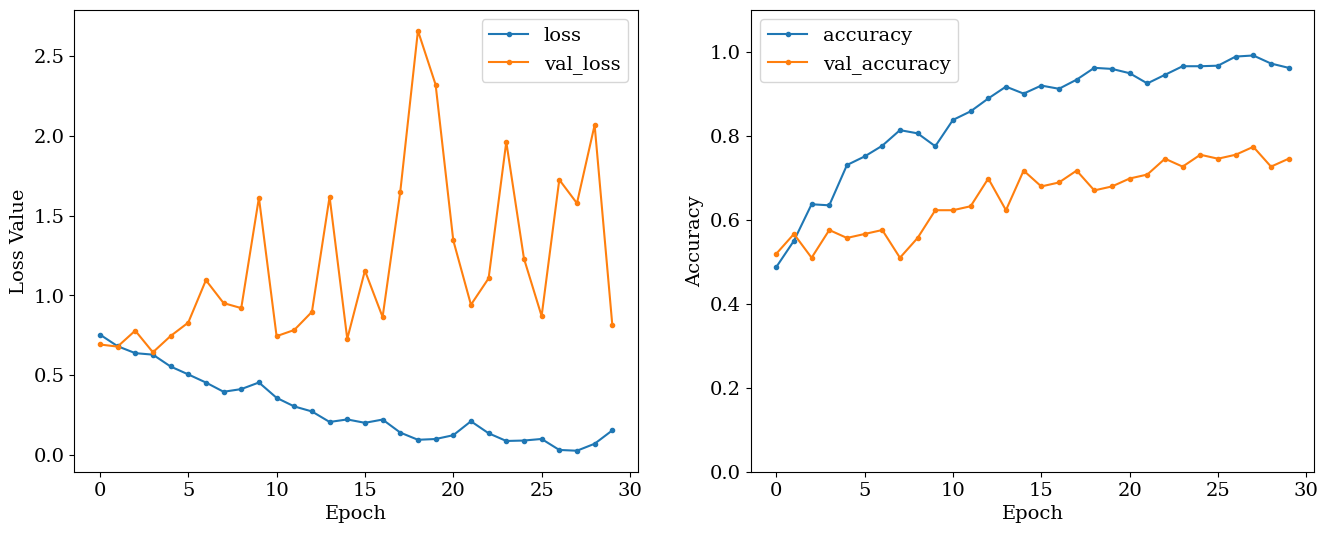

In [92]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], '.-')
plt.plot(history.history['val_loss'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend(['loss', 'val_loss'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], '.-')
plt.plot(history.history['val_accuracy'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.1])
plt.legend(['accuracy', 'val_accuracy'])

plt.show()

### Loading the best checkpoint and evaluating the model using the test dataset

In [93]:
vgg16_model = keras.models.load_model('vgg16_model-noTL.keras')

vgg16_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=BinaryCrossentropy(),
    metrics=[
        BinaryAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall'),
        F1Score(name='f1score'),
    ]
)

eval = vgg16_model.evaluate(test_ds, return_dict=True)

eval

5/5 [==============================] - 1s 107ms/step - loss: 0.6178 - accuracy: 0.6187 - precision: 0.8000 - recall: 0.3415 - f1score: 0.6777   


{'loss': 0.6178138852119446,
 'accuracy': 0.6187499761581421,
 'precision': 0.800000011920929,
 'recall': 0.3414634168148041,
 'f1score': array([0.6776859], dtype=float32)}

# VGG16 Model with Imagenet Weights

### Creating the VGG16 Model and viewing its Summary
We apply transfer learning using the VGG16 model by first loading it using weights of the ImageNet dataset.

In [94]:
vgg16_model = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=image_size+(3,))

inputs = vgg16_model.input
x = Flatten()(vgg16_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

vgg16_model = keras.Model(inputs, outputs, name='VGG16_Model_TL')
vgg16_model.summary(show_trainable=True)

Model: "VGG16_Model_TL"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_9 (InputLayer)        [(None, 256, 256, 3)]     0         Y          
                                                                            
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      Y          
                                                                            
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     Y          
                                                                            
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         Y          
                                                                            
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     Y          
                                                                            
 block2_conv2 (Conv2D)       (None, 128, 128, 128)  

### Freeze Layers
First, we freeze the base model and only train the newly added layers. After that, we evaluate the model at this stage.

In [95]:
for layer in vgg16_model.layers[:-4]:
  layer.trainable = False
vgg16_model.summary(show_trainable=True)

Model: "VGG16_Model_TL"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_9 (InputLayer)        [(None, 256, 256, 3)]     0         N          
                                                                            
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      N          
                                                                            
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     N          
                                                                            
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         N          
                                                                            
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     N          
                                                                            
 block2_conv2 (Conv2D)       (None, 128, 128, 128)  

### Apply Preprocessing Function
Since we are using pretrained weights, we need to preprocess our inputs with an appropiate preprocessing function. One way of doing this is to map the preprocessing function to the dataset object.

In [96]:
prep_train_ds = train_ds.map(lambda x, y: (vgg16.preprocess_input(x), y))
prep_val_ds = val_ds.map(lambda x, y: (vgg16.preprocess_input(x), y))
prep_test_ds = test_ds.map(lambda x, y: (vgg16.preprocess_input(x), y))

### Compile and Fit the model

In [97]:
vgg16_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=BinaryCrossentropy(),
    metrics=[BinaryAccuracy(name='accuracy')]
)

history = vgg16_model.fit(
    prep_train_ds,
    validation_data=prep_val_ds,
    epochs=epochs,
    callbacks=[
        ModelCheckpoint('vgg16_model-halfTL.keras', monitor=monitor_metric, save_weights_only=False, save_best_only=True, verbose=1),
    ],
)

Epoch 1/30


25/25 [==============================] - ETA: 0s - loss: 0.9454 - accuracy: 0.8069
Epoch 1: val_loss improved from inf to 0.76043, saving model to vgg16_model-halfTL.keras
25/25 [==============================] - 4s 137ms/step - loss: 0.9454 - accuracy: 0.8069 - val_loss: 0.7604 - val_accuracy: 0.8302
Epoch 2/30
25/25 [==============================] - ETA: 0s - loss: 0.0303 - accuracy: 0.9898
Epoch 2: val_loss did not improve from 0.76043
25/25 [==============================] - 3s 122ms/step - loss: 0.0303 - accuracy: 0.9898 - val_loss: 0.8223 - val_accuracy: 0.8491
Epoch 3/30
25/25 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 0.76043
25/25 [==============================] - 3s 120ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.9595 - val_accuracy: 0.8585
Epoch 4/30
25/25 [==============================] - ETA: 0s - loss: 1.9065e-04 - accuracy: 1.0000
Epoch 4: val_loss did not improve from 0.76043
25/25 [=

### Plot loss and accuracy graphs

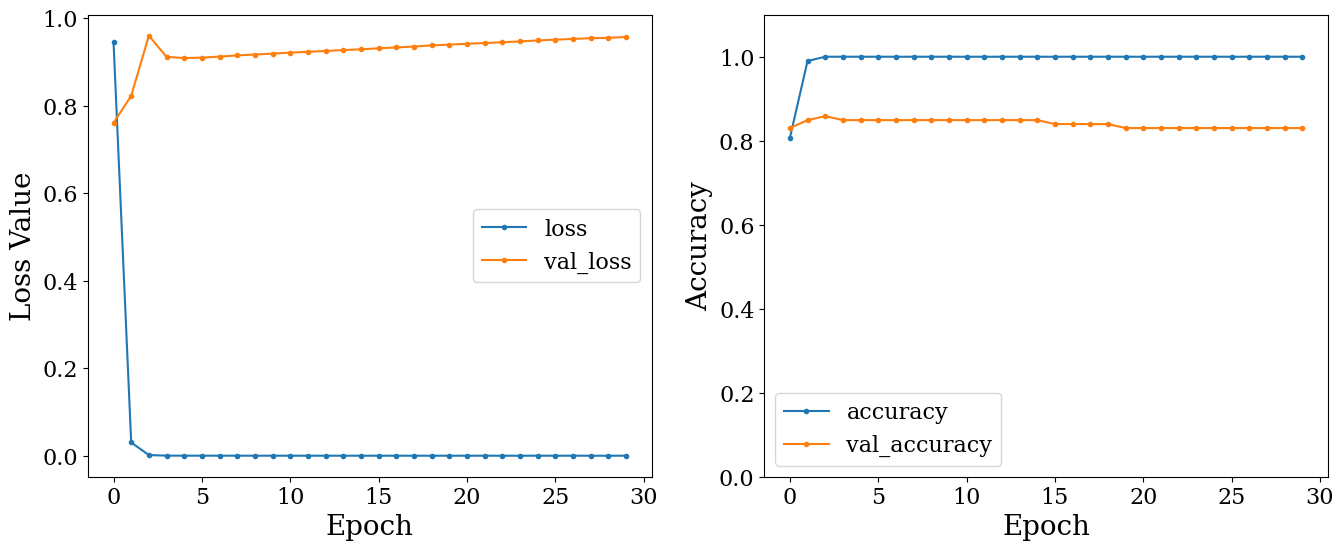

In [98]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], '.-')
plt.plot(history.history['val_loss'], '.-')
plt.xlabel('Epoch', fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Loss Value',fontsize=20)
plt.yticks(fontsize=16)
plt.legend(['loss', 'val_loss'],fontsize=16)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], '.-')
plt.plot(history.history['val_accuracy'], '.-')
plt.xlabel('Epoch',fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Accuracy',fontsize=20)
plt.yticks(fontsize=16)
plt.ylim([0, 1.1])
plt.legend(['accuracy', 'val_accuracy'],fontsize=16)

plt.show()

### Load the best checkpoint and evaluate the model using the test dataset

In [99]:
vgg16_model = keras.models.load_model('vgg16_model-halfTL.keras')

vgg16_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=BinaryCrossentropy(),
    metrics=[
        BinaryAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall'),
        F1Score(name='f1score'),
    ]
)

eval = vgg16_model.evaluate(prep_test_ds, return_dict=True)

eval

5/5 [==============================] - 1s 104ms/step - loss: 1.3942 - accuracy: 0.8125 - precision: 0.9483 - recall: 0.6707 - f1score: 0.6987   


{'loss': 1.394209623336792,
 'accuracy': 0.8125,
 'precision': 0.9482758641242981,
 'recall': 0.6707317233085632,
 'f1score': array([0.69869], dtype=float32)}

## Unfreeze all the layers
Now, we unfreeze all the layers and compile and train the model again using the training dataset.

In [100]:
for layer in vgg16_model.layers:
  layer.trainable = True
vgg16_model.summary(show_trainable=True)

Model: "VGG16_Model_TL"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_9 (InputLayer)        [(None, 256, 256, 3)]     0         Y          
                                                                            
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      Y          
                                                                            
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     Y          
                                                                            
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         Y          
                                                                            
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     Y          
                                                                            
 block2_conv2 (Conv2D)       (None, 128, 128, 128)  

### Compile and Fit the Model

In [101]:
vgg16_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=BinaryCrossentropy(),
    metrics=[BinaryAccuracy(name='accuracy')]
)

history = vgg16_model.fit(
    prep_train_ds,
    validation_data=prep_val_ds,
    epochs=epochs,
    callbacks=[
        ModelCheckpoint('vgg16_model-fullTL.keras', monitor=monitor_metric, save_weights_only=False, save_best_only=True, verbose=1),
    ],
)

Epoch 1/30


25/25 [==============================] - ETA: 0s - loss: 0.9877 - accuracy: 0.7366
Epoch 1: val_loss improved from inf to 0.69386, saving model to vgg16_model-fullTL.keras
25/25 [==============================] - 10s 301ms/step - loss: 0.9877 - accuracy: 0.7366 - val_loss: 0.6939 - val_accuracy: 0.7642
Epoch 2/30
25/25 [==============================] - ETA: 0s - loss: 0.2015 - accuracy: 0.9118
Epoch 2: val_loss did not improve from 0.69386
25/25 [==============================] - 7s 282ms/step - loss: 0.2015 - accuracy: 0.9118 - val_loss: 1.0057 - val_accuracy: 0.8019
Epoch 3/30
25/25 [==============================] - ETA: 0s - loss: 0.0824 - accuracy: 0.9719
Epoch 3: val_loss improved from 0.69386 to 0.50992, saving model to vgg16_model-fullTL.keras
25/25 [==============================] - 8s 311ms/step - loss: 0.0824 - accuracy: 0.9719 - val_loss: 0.5099 - val_accuracy: 0.8679
Epoch 4/30
25/25 [==============================] - ETA: 0s - loss: 0.0357 - accuracy: 0.9885
Epoch 4: val

### Plotting loss and accuracy graphs

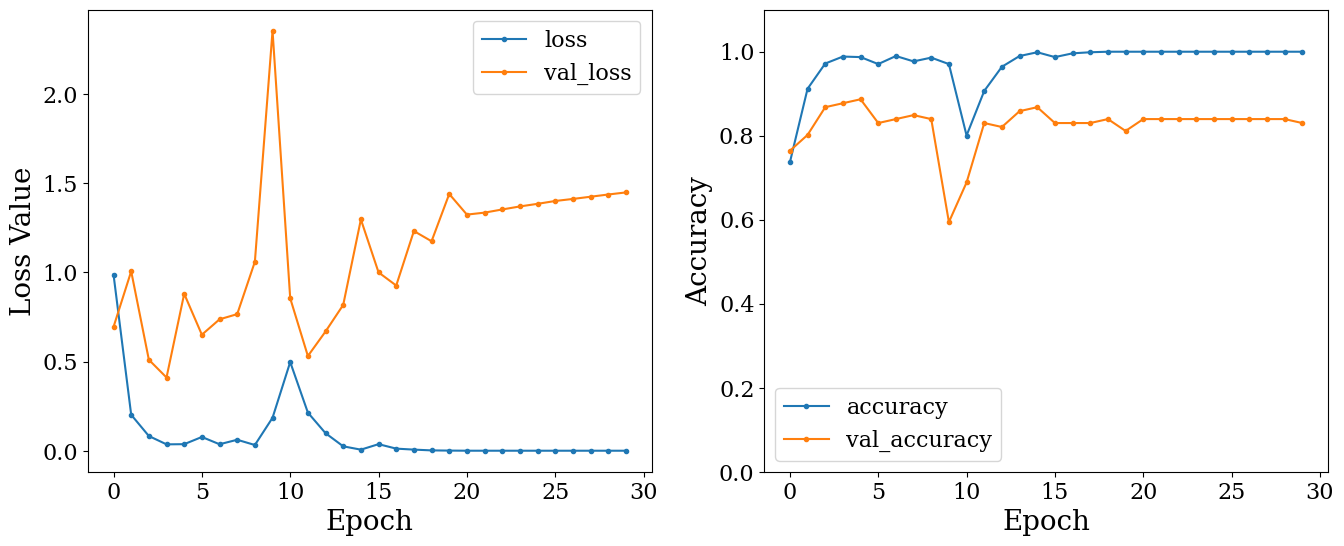

In [102]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], '.-')
plt.plot(history.history['val_loss'], '.-')
plt.xlabel('Epoch', fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Loss Value',fontsize=20)
plt.yticks(fontsize=16)
plt.legend(['loss', 'val_loss'],fontsize=16)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], '.-')
plt.plot(history.history['val_accuracy'], '.-')
plt.xlabel('Epoch',fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Accuracy',fontsize=20)
plt.yticks(fontsize=16)
plt.ylim([0, 1.1])
plt.legend(['accuracy', 'val_accuracy'],fontsize=16)

# plt.savefig("./{}.eps".format('vgg-c-2'), bbox_inches='tight', format='eps', dpi=1000)
plt.show()

### Load the best checkpoint and evaluate the model using the test dataset

In [103]:
vgg16_model = keras.models.load_model('vgg16_model-fullTL.keras')

vgg16_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=BinaryCrossentropy(),
    metrics=[
        BinaryAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall'),
        F1Score(name='f1score'),
    ]
)

eval = vgg16_model.evaluate(prep_test_ds, return_dict=True)

eval

5/5 [==============================] - 1s 103ms/step - loss: 0.7387 - accuracy: 0.7875 - precision: 1.0000 - recall: 0.5854 - f1score: 0.6805   


{'loss': 0.7386841773986816,
 'accuracy': 0.7875000238418579,
 'precision': 1.0,
 'recall': 0.5853658318519592,
 'f1score': array([0.68049794], dtype=float32)}